# ML model using scorecard data

This notebook explores whether machine learning methods have better predictive abilities than the "traditional" data analytics approach of running a linear regression equation on all *a priori* explanatory variables (features), i.e. the "kitchen-sink" approach. This is done using data from the College Scorecard linked geographically to variables on economic conditions. Both these approaches are correlational in nature. No causal mechanism should be interpreted from the results.

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
# import missingno as miss

# Plotting libraries
# from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
# from sklearn.compose import ColumnTransformer 
from sklearn import linear_model
from sklearn import impute

# For splits and CV
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold # Cross validation 
# from sklearn.model_selection import cross_validate # Cross validation 
# from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
# from sklearn.naive_bayes import GaussianNB as NB
# from sklearn.neighbors import KNeighborsClassifier as KNN
# from sklearn.tree import DecisionTreeClassifier as DT
# from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
# from sklearn.linear_model import SGDRegressor as SGD

# from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
# from sklearn.inspection import (
#     permutation_importance,
#     partial_dependence, 
#     PartialDependenceDisplay, 
#     plot_partial_dependence
# )

# import requests
# from bs4 import BeautifulSoup
from random import randint
# from time import sleep

import re
import time
import math
import operator

# Misc
import warnings
warnings.filterwarnings("ignore")

## Read data and get columns to use for ML

Note: race variables change depending on year of data collection. Not all variables are collected every year so only those with count > 0 are kept

In [2]:
def getdata(csvfile):
    # read csv file
    scard = pd.read_csv(csvfile, na_values = 'PrivacySuppressed')
    # get metadata on numeric values
    scard_metadata = scard.describe().transpose()
    # get column names of all variables and convert to df
    cols = scard.columns.values
    cols = pd.DataFrame(cols, columns = ['column_name'])
    # Extract column names for share of students in different majors
    major_cols = cols.loc[cols['column_name'].str.startswith('PCIP')]['column_name'].values.tolist()
    # Extract column names for race shares of students
    race_cols = cols.loc[cols['column_name'].str.startswith('UGDS_')]['column_name'].values.tolist()
    # List of other variables to use combined with majors and race
    cols_to_keep = ['UNITID', 'OPEID', 'OPEID6', 'INSTNM', 'CITY', 'STABBR', 'MAIN', 'PREDDEG', 'CONTROL', 'ICLEVEL', 'ST_FIPS', 'LOCALE', 'CCBASIC', 'HIGHDEG',
    'ADM_RATE', 'SATVRMID', 'SATMTMID', 'SATWRMID', 'ACTCMMID', 'ACENMID', 'ACTMTMID', 'ACTWRMID', 'AVGFACSAL', 'PFTFAC', 'PCTPELL', 'C150_L4', 'C150_4', 'RET_FT4',
    'RET_FTL4','OPENADMP', 'MD_EARN_WNE_P10', 'MD_EARN_WNE_P8', 'MD_EARN_WNE_P6'] + major_cols + race_cols
    vars_to_use = scard_metadata.filter(items=cols_to_keep, axis=0)
    # keep only meta data on variables that have values
    vars_to_use = vars_to_use.loc[vars_to_use['count'] > 0]
    # keep only data frame with colums to use
    scard = scard[list(vars_to_use.index.values)]

    return (scard, scard_metadata, vars_to_use, major_cols)

In [3]:
(scard1819, scard_metadata, vars_to_use, major_cols) = getdata('MERGED2018_19_PP.csv')

## Subset data and create variables

1. create new admission rate combining open admissions indicator and existing admission rate
2. create categorical variables
3. collapse share of students in majors

In [4]:
def createVars(datain, major_cols):
    # Create new admission rate variable
    datain['admrate'] = np.where(datain['OPENADMP']==1, 1, datain['ADM_RATE'])
    # Collapse majors
    datain = datain.assign(major_stem_quant = datain.PCIP04 + datain.PCIP11 + datain.PCIP14 + datain.PCIP15 + datain.PCIP27 + datain.PCIP40 + datain.PCIP41,
    major_stem_nonquant = datain.PCIP01 + datain.PCIP03 + datain.PCIP26 + datain.PCIP42,
    major_business = datain.PCIP52,
    major_ahla = datain.PCIP05 + datain.PCIP09 + datain.PCIP16 + datain.PCIP23 + datain.PCIP24 + datain.PCIP30 + datain.PCIP38 + datain.PCIP39 + datain.PCIP54,
    major_career = datain.PCIP10 + datain.PCIP12 + datain.PCIP19 + datain.PCIP22 + datain.PCIP46 + datain.PCIP47 + datain.PCIP48 + datain.PCIP49,
    major_ts = datain.PCIP13 + datain.PCIP25 + datain.PCIP31 + datain.PCIP43 + datain.PCIP44 + datain.PCIP45 + datain.PCIP51)
    # drop source variables for majors
    datain = datain.drop(major_cols, axis=1)
    # Keep only certificates, associate's and bachelor's degrees
    datain = datain.query('PREDDEG > 0 & PREDDEG < 4')
    # Create grad school variable
    datain['hasGradSchool'] = datain['HIGHDEG'] == 4
    datain['hasGradSchool'] = datain['hasGradSchool'].astype(int)
    # Create categorical variables
    # datain['HIGHDEG'] = datain['HIGHDEG'].astype('category')
    datain['ICLEVEL'] = datain['ICLEVEL'].astype('category')
    datain['CONTROL'] = datain['CONTROL'].astype('category')
    datain['PREDDEG'] = datain['PREDDEG'].astype('category')
    # Define categorical variables
    # datain['HIGHDEG'] = datain['HIGHDEG'].cat.rename_categories({1: "Certificate", 2: "Asssociate's", 3: "Bachelor's", 4: "Graduate"})
    datain['ICLEVEL'] = datain['ICLEVEL'].cat.rename_categories({1: "4-year", 2: "2-year", 3: "Less than 2-year"})
    # datain['PREDDEG'] = datain['PREDDEG'].cat.rename_categories({0: "Not classified", 1: "Predominantly certificate", 2: "Predominantly asssociate's", 3: "Predominantly bachelor's", 4: "Entirely graduate"})
    datain['PREDDEG'] = datain['PREDDEG'].cat.rename_categories({1: "Predominantly certificate", 2: "Predominantly asssociate's", 3: "Predominantly bachelor's"})
    datain['CONTROL'] = datain['CONTROL'].cat.rename_categories({1: "Public", 2: "Private nonprofit", 3: "Private for-profit"})
    control = pd.get_dummies(datain['CONTROL'])
    datain = datain.merge(control, left_index = True, right_index = True)
    
    return datain


In [5]:
scard_ml = createVars(scard1819, major_cols=major_cols)
scard_ml.dropna(subset=['MD_EARN_WNE_P10'], inplace=True)

## Merge additional data

Additional contextual data on the economic condition at the expected time of completion may be able to explain earnings. Note however that the earnings in the College Scorecard includes non-completers.

1. County name/code from IPEDS
  - provides linkage to scorecard UNITID and county codes
2. County poverty rate/unemployment rate from 2008
  - 2008 is used because this is the assumed year of exit from 4-year institutions
  - unemployment rates are from Local Area Unemployment Statistics
  - poverty rates are from Small Area Income and Poverty Estimates 
3. State unemployment rates
  - From BLS for all available years, rows are states, columns are month/year with an additional column for annual average

In [6]:
def getAdditionalData(df, lau, saipe, unempyear):
    ipeds = pd.read_excel("EDGE_GEOCODE_POSTSECSCH_1819.xlsx") #"EDGE_GEOCODE_POSTSECSCH_1819.xlsx"/ipedsfile
    carnegie = pd.read_excel("CCIHE2018-PublicDataFile.xlsx", sheet_name = "Data") # Carnegie classifications
    carnegie = carnegie[['UNITID', 'BASIC2018']]
    ccbasic = pd.get_dummies(carnegie['BASIC2018'], prefix = 'ccbasic')
    carnegie = carnegie.merge(ccbasic, left_index = True, right_index = True)
    urate = pd.read_excel(lau, skiprows=6, header=None, dtype=object) # laucnty08.xlsx/uratefile
    saipe = pd.read_excel(saipe, skiprows=6, header=None, dtype=object, na_values='.') # poverty/saipe file
    ipeds_out = ipeds[['UNITID', 'STFIP', 'STATE', 'CNTY', 'NMCNTY']]
    urate_out = pd.DataFrame()
    urate_out['CNTY'] = urate[1] + urate[2]
    urate_out['urate'] = urate[9].astype(float)
    saipe_out = pd.DataFrame()
    saipe_out['CNTY'] = saipe[0] + saipe[1].apply(lambda x: str(x).zfill(3))
    saipe_out['povrate'] = saipe[7].astype(float)
    saipe_out['median_hh_inc'] = saipe[22].astype(float)
    saipe_out = saipe_out.dropna().query('CNTY != "00000"') # remove USA

    addtl_data = ipeds_out.merge(carnegie, how='inner', on='UNITID')
    addtl_data = addtl_data.merge(urate_out, how='inner', on='CNTY')
    addtl_data = addtl_data.merge(saipe_out, how='inner', on='CNTY')
    
    state_unemployment_raw = pd.read_csv("StateUnemploymentRates.csv")
    numcols = state_unemployment_raw.shape[1] - 3
    cols = ["STABBR", "STATE", "ID"] + ["SEQ" + str(i) for i in range(numcols)] # rename month/year columns to something easier to work with
    state_unemployment_raw.columns = cols
    state_unemployment = pd.wide_to_long(state_unemployment_raw, stubnames=["SEQ"], i="STABBR", j="MON").reset_index()
    state_unemployment["MON"] = state_unemployment["MON"] + 1
    state_unemployment["MONTH"] = state_unemployment['MON'] % 13 # divide by 13 takes care of data in 'annual' which appears after month 12
    state_unemployment = state_unemployment.loc[state_unemployment['MONTH'] != 0] # Remove annual data
    state_unemployment["YEAR"] = (state_unemployment['MON'] // 13) + 1976 # Create year variable
    state_unemployment = state_unemployment.dropna()
    state_unemployment.rename(columns = {'SEQ': 'state_urate'}, inplace=True)
    state_unemployment_use = state_unemployment.loc[(state_unemployment['YEAR']==unempyear)]
    state_unemployment_use = pd.DataFrame(state_unemployment_use.groupby('STABBR')['state_urate'].mean())

    addtl_data = addtl_data.merge(state_unemployment_use, how='inner', left_on='STATE', right_on='STABBR')
    df = df.merge(addtl_data, how = 'inner', on='UNITID')

    return df
    
scard_ml = getAdditionalData(df = scard_ml, lau = "laucnty18.xlsx", saipe = "est18all.xls", unempyear=2018)

## Data exploration

1. How do earnings vary by degree?
2. How do earnings vary by type of institution?

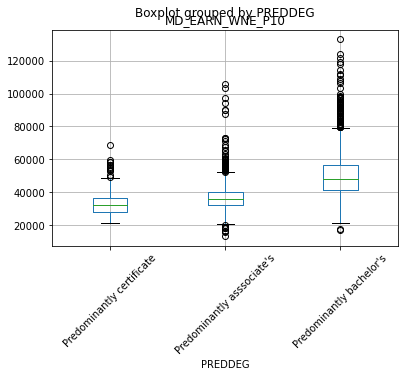

In [7]:
scard_ml.boxplot(column=['MD_EARN_WNE_P10'], by='PREDDEG', rot=45);

Earnings are generally lower at less than 4-year institutions. For this reason, consider only institutions that predominantly award bachelor's degrees.

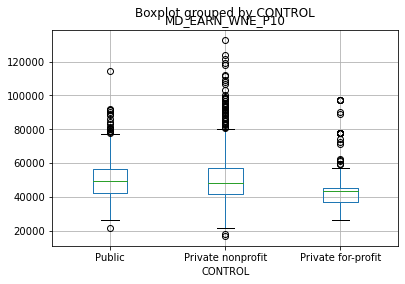

In [8]:
## Subset to just bachelor's degrees

ba_ml = scard_ml.loc[scard_ml.PREDDEG == "Predominantly bachelor's"] # scard_ml.query('PREDDEG == "Predominantly bachelor\'s"')
ba_ml.boxplot(column=['MD_EARN_WNE_P10'], by='CONTROL');

Now, earnings 10 years after enrollment at public institutions are similar to those from private nonprofit institutions

### Test scores and admissions rate

Possible predictors for earnings could be test scores and the share of low income students at the institution. However, due to the existence of test optional and open admission colleges that do not require test scores be submitted test scores will be missing for these institutions. It is possible that admission rates could work as a proxy for test scores.

In [9]:
ba_ml[['MD_EARN_WNE_P10', 'ADM_RATE', 'admrate', 'PCTPELL', 'SATVRMID', 'SATMTMID', 'ACTCMMID']].describe()

,MD_EARN_WNE_P10,ADM_RATE,admrate,PCTPELL,SATVRMID,SATMTMID,ACTCMMID
count,1813.000000,1526.000000,1730.000000,1813.000000,1175.000000,1177.000000,1207.000000
mean,50635.338665,0.671263,0.710027,0.383591,566.352340,561.672897,23.634631
std,14132.162734,0.206031,0.220652,0.163538,61.215055,69.437959,3.717855
min,16792.000000,0.000000,0.000000,0.000000,300.000000,370.000000,15.000000
25%,41549.000000,0.558850,0.579400,0.267200,525.000000,515.000000,21.000000
50%,48092.000000,0.692600,0.728200,0.364700,560.000000,550.000000,23.000000
75%,56800.000000,0.825250,0.890500,0.476100,600.000000,590.000000,25.000000
max,132969.000000,1.000000,1.000000,1.000000,760.000000,795.000000,36.000000


As expected test scores have a higher rate of missingness than admission rates. Can admission rates substitute for test scores to predict earnings?

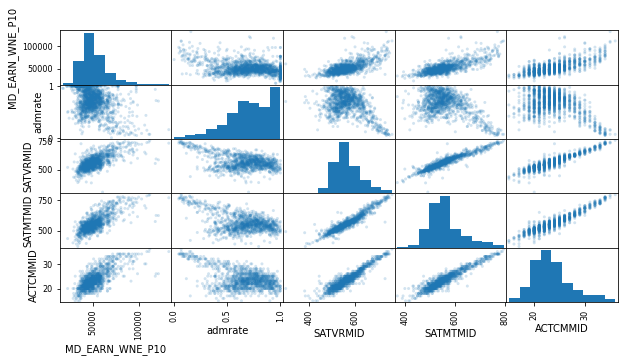

In [10]:
pd.plotting.scatter_matrix(ba_ml[['MD_EARN_WNE_P10', 'admrate', 'SATVRMID', 'SATMTMID', 'ACTCMMID']], alpha=0.2, figsize=(10,5));

As the scatter plot matrix shows, admission rates are not a good proxy for test scores. The correlation of admission rates (admrate) and earnings (MD_EARN_WNE_P10) does not appear to be as high as the corrleation of earnings with test scores: SAT verbal (SATVRMID), SAT Math (SATMTMID) or combined ACT (ACTCMMID). Since missing test scores may not be missing at random, mean or median substitution may not work well. One possibility is to impute test scores using linear regression. Moreover, since all the test scores are highly correlated, it may not matter which one we use.

In [11]:
ba_ml[['admrate', 'PCTPELL', 'SATVRMID', 'SATMTMID', 'ACTCMMID']].corr()

,admrate,PCTPELL,SATVRMID,SATMTMID,ACTCMMID
admrate,1.000000,0.288275,-0.430817,-0.467997,-0.452910
PCTPELL,0.288275,1.000000,-0.693181,-0.707979,-0.730543
SATVRMID,-0.430817,-0.693181,1.000000,0.942531,0.925167
SATMTMID,-0.467997,-0.707979,0.942531,1.000000,0.942396
ACTCMMID,-0.452910,-0.730543,0.925167,0.942396,1.000000


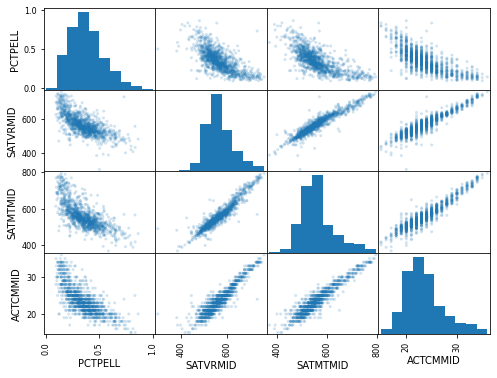

In [12]:
pd.plotting.scatter_matrix(ba_ml[['PCTPELL', 'SATVRMID', 'SATMTMID', 'ACTCMMID']], alpha=0.2, figsize=(8,6));

### Impute test scores

Impute ACT using linear regression on PCTPELL

In [13]:
# Explore regression specifications for imputation

import statsmodels.api as sm

def specRegression(X, y, addConstant = 1): 
    if addConstant == 1:
        X = sm.add_constant(X)

    model = sm.OLS(y, X, missing='drop')
    results = model.fit()
    return results

print(specRegression(X=ba_ml[['PCTPELL', 'admrate']], y=ba_ml['ACTCMMID']).summary())

                            OLS Regression Results                            
Dep. Variable:               ACTCMMID   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     1166.
Date:                Wed, 03 Aug 2022   Prob (F-statistic):          2.10e-282
Time:                        15:19:29   Log-Likelihood:                -2646.9
No. Observations:                1207   AIC:                             5300.
Df Residuals:                    1204   BIC:                             5315.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.4155      0.251    137.147      0.0

In [14]:
def imputeWithLinearRegression(df, X, y):
    imp_data = df[X + y].dropna(axis=0, how='any')
    # Get not in imp_data for prediction
    # See https://stackoverflow.com/questions/29134635/slice-pandas-dataframe-by-index-values-that-are-not-in-a-list
    # for other approaches
    impute_index = set(df.index) - set(imp_data.index) 

    imp_model = linear_model.LinearRegression()
    imp_model.fit(X=imp_data[X], y=imp_data[y])

    pred = df.loc[impute_index][X].dropna()
    predvar = y[0] + '_pred'
    pred[predvar] = imp_model.predict(pred[X])
    df[predvar] = df[y[0]]
    df.loc[impute_index, predvar] = pred[predvar]

    return df

ba_ml = imputeWithLinearRegression(df=ba_ml, X=['PCTPELL', 'admrate'], y=['ACTCMMID'])

In [15]:
# Impute with other approaches to see if there are substantial differences

def otherImputation(df):
    df['ACTCMMID_medfill'] = df['ACTCMMID'].fillna(df['ACTCMMID'].median())
    ACTCMMID_knn = ba_ml[['ACTCMMID', 'admrate', 'PCTPELL']]
    knnImputer = impute.KNNImputer()
    knnImputer.fit(ACTCMMID_knn)
    df['ACTCMMID_knn'] = knnImputer.fit_transform(ACTCMMID_knn)[:,0]
    return df

ba_ml = otherImputation(ba_ml)

In [16]:
ba_ml[['ACTCMMID_medfill', 'ACTCMMID_pred', 'ACTCMMID_knn']].describe()

,ACTCMMID_medfill,ACTCMMID_pred,ACTCMMID_knn
count,1813.000000,1730.000000,1813.000000
mean,23.422504,22.656823,22.977165
std,3.047849,4.121065,3.680956
min,15.000000,9.396285,15.000000
25%,22.000000,20.000000,20.200000
50%,23.000000,22.298597,22.000000
75%,24.000000,25.000000,25.000000
max,36.000000,36.000000,36.000000


For now, this is the only variable we will impute. Drop the other test variables as well as unneeded columns from the data frame.

In [17]:
ba_ml_1819 = ba_ml.copy()
ba_ml.drop(axis = 1, columns = ['SATVRMID', 'SATMTMID', 'ACTCMMID', 'ACTMTMID', 'OPENADMP', 'PREDDEG', 'UNITID', 'OPEID', 'OPEID6', 'MAIN', 
'ICLEVEL', 'C150_L4', 'ST_FIPS', 'CONTROL', 'HIGHDEG', 'ADM_RATE', 'RET_FTL4', 'MD_EARN_WNE_P8', 'MD_EARN_WNE_P6'], inplace = True)

In [18]:
pd.DataFrame(ba_ml.describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
AVGFACSAL,1772.0,7868.194695,2456.402510,500.000000,6305.000000,7531.000000,9086.250000,20483.000000
PFTFAC,1733.0,0.649358,0.269657,0.000000,0.455000,0.666700,0.892900,1.000000
PCTPELL,1813.0,0.383591,0.163538,0.000000,0.267200,0.364700,0.476100,1.000000
C150_4,1716.0,0.535746,0.203721,0.000000,0.399475,0.540750,0.672925,1.000000
RET_FT4,1687.0,0.738271,0.148450,0.000000,0.666700,0.754700,0.831950,1.000000
...,...,...,...,...,...,...,...,...
median_hh_inc,1813.0,62228.372863,16179.267297,26814.000000,50928.000000,59838.000000,69562.000000,125933.000000
state_urate,1813.0,3.836326,0.622813,2.358333,3.400000,3.983333,4.258333,5.966667
ACTCMMID_pred,1730.0,22.656823,4.121065,9.396285,20.000000,22.298597,25.000000,36.000000
ACTCMMID_medfill,1813.0,23.422504,3.047849,15.000000,22.000000,23.000000,24.000000,36.000000


In [19]:
ba_ml.dropna(inplace=True)
pd.DataFrame(ba_ml.describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
AVGFACSAL,1631.0,7948.339056,2455.084797,1236.000000,6396.500000,7594.000000,9160.500000,20483.000000
PFTFAC,1631.0,0.654166,0.263675,0.024400,0.462400,0.667200,0.891150,1.000000
PCTPELL,1631.0,0.375786,0.156551,0.089200,0.265150,0.360000,0.464150,1.000000
C150_4,1631.0,0.548544,0.193925,0.000000,0.421300,0.549100,0.682000,1.000000
RET_FT4,1631.0,0.742487,0.137550,0.000000,0.668350,0.756600,0.831000,1.000000
...,...,...,...,...,...,...,...,...
median_hh_inc,1631.0,61996.538320,16183.442087,26814.000000,50501.000000,59443.000000,68978.000000,125933.000000
state_urate,1631.0,3.840430,0.621341,2.358333,3.408333,3.983333,4.258333,5.966667
ACTCMMID_pred,1631.0,22.894404,4.003588,9.396285,20.292554,22.917120,25.000000,36.000000
ACTCMMID_medfill,1631.0,23.475169,3.202256,15.000000,22.000000,23.000000,24.000000,36.000000


In [20]:
ba_ml[ba_ml.columns[ba_ml.columns.str.startswith('ccbasic')]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ccbasic_1,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ccbasic_2,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ccbasic_3,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ccbasic_4,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ccbasic_5,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ccbasic_6,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ccbasic_7,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ccbasic_8,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ccbasic_9,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
ccbasic_10,1631.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [21]:
ba_ml[ba_ml.columns[ba_ml.columns.str.startswith('UGDS')]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
UGDS_WHITE,1631.0,0.559026,0.228328,0.0,0.43530,0.6098,0.73155,1.0000
UGDS_BLACK,1631.0,0.145827,0.192153,0.0,0.04295,0.0795,0.15945,0.9837
UGDS_HISP,1631.0,0.118779,0.122256,0.0,0.04515,0.0788,0.14095,0.9758
UGDS_ASIAN,1631.0,0.044727,0.060062,0.0,0.01120,0.0233,0.05055,0.5324
UGDS_AIAN,1631.0,0.007569,0.034070,0.0,0.00150,0.0030,0.00580,0.9680
UGDS_NHPI,1631.0,0.002567,0.007506,0.0,0.00040,0.0010,0.00250,0.2246
UGDS_2MOR,1631.0,0.035905,0.026064,0.0,0.02220,0.0332,0.04470,0.3364
UGDS_NRA,1631.0,0.044280,0.058440,0.0,0.01020,0.0251,0.05555,0.6029
UGDS_UNKN,1631.0,0.041320,0.057893,0.0,0.01030,0.0250,0.05015,0.7318
UGDS_MEN,1631.0,0.433364,0.136116,0.0,0.37530,0.4323,0.49310,1.0000


## "Traditional" analytics approach

This approach estimates a linear model using various characteristics and compares R-squares. As a baseline for ML models, a "benchmark" RMSE is computed. This is the RMSE that ML models have to beat.

In [22]:
inst_qual = ['AVGFACSAL', 'PFTFAC']
inst_ugdschar = ['PCTPELL', 'UGDS_WOMEN', 'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN', 'UGDS_NHPI', 'UGDS_2MOR', 'UGDS_NRA'] # left out 'UGDS_MEN',  UGDS_UNKN
inst_char = ['admrate', 'C150_4', 'RET_FT4', 'Private for-profit', 'Private nonprofit', 'Public', 'hasGradSchool']
inst_major = ['major_stem_quant', 'major_stem_nonquant', 'major_business', 'major_ahla', 'major_career', 'major_ts']
ccbasic = ['ccbasic_' + str(i) for i in range(15,34)] # only applies to bachelor's and higher
test_scores = ['ACTCMMID_pred', 'ACTCMMID_medfill', 'ACTCMMID_knn']
econ_var = ['urate', 'povrate', 'median_hh_inc']

### Correlation of explanatory variables

In [23]:
corr = pd.DataFrame(ba_ml[inst_char[0:3] + inst_qual + inst_ugdschar + inst_major + test_scores + econ_var].corr())
corr.style.background_gradient(cmap = 'coolwarm', axis=None).set_precision(2)

,admrate,C150_4,RET_FT4,AVGFACSAL,PFTFAC,PCTPELL,UGDS_WOMEN,UGDS_WHITE,UGDS_BLACK,UGDS_HISP,UGDS_ASIAN,UGDS_AIAN,UGDS_NHPI,UGDS_2MOR,UGDS_NRA,major_stem_quant,major_stem_nonquant,major_business,major_ahla,major_career,major_ts,ACTCMMID_pred,ACTCMMID_medfill,ACTCMMID_knn,urate,povrate,median_hh_inc
admrate,1.00,-0.45,-0.35,-0.42,-0.18,0.27,0.04,0.06,0.07,0.03,-0.30,0.08,0.09,-0.10,-0.27,-0.13,-0.20,0.14,-0.01,0.11,0.09,-0.55,-0.40,-0.52,-0.05,-0.02,-0.04
C150_4,-0.45,1.00,0.75,0.61,0.24,-0.64,-0.04,0.28,-0.43,-0.06,0.37,-0.15,-0.09,0.13,0.27,0.23,0.27,-0.21,-0.03,-0.07,-0.17,0.76,0.66,0.77,-0.08,-0.13,0.19
RET_FT4,-0.35,0.75,1.00,0.58,0.23,-0.58,-0.09,0.22,-0.39,0.01,0.37,-0.13,-0.08,0.10,0.25,0.27,0.22,-0.22,-0.01,-0.04,-0.18,0.69,0.58,0.68,-0.01,-0.07,0.17
AVGFACSAL,-0.42,0.61,0.58,1.00,0.14,-0.51,-0.03,-0.06,-0.26,0.14,0.60,-0.10,-0.03,0.21,0.31,0.43,0.18,-0.08,-0.18,-0.05,-0.13,0.70,0.65,0.71,0.00,-0.09,0.28
PFTFAC,-0.18,0.24,0.23,0.14,1.00,-0.19,-0.13,0.19,-0.09,-0.17,-0.05,0.05,-0.06,0.06,0.03,0.09,0.21,-0.16,0.09,-0.04,0.00,0.24,0.16,0.23,0.02,0.13,-0.26
PCTPELL,0.27,-0.64,-0.58,-0.51,-0.19,1.00,0.10,-0.51,0.62,0.19,-0.22,0.07,0.07,-0.18,-0.28,-0.25,-0.13,0.09,0.12,0.09,0.08,-0.82,-0.57,-0.76,0.17,0.18,-0.14
UGDS_WOMEN,0.04,-0.04,-0.09,-0.03,-0.13,0.10,1.00,-0.15,0.16,0.06,0.01,0.01,0.03,0.02,-0.11,-0.41,0.10,-0.05,-0.20,-0.12,0.45,-0.10,-0.12,-0.12,-0.00,0.03,0.02
UGDS_WHITE,0.06,0.28,0.22,-0.06,0.19,-0.51,-0.15,1.00,-0.64,-0.49,-0.32,-0.08,-0.16,-0.02,-0.20,-0.04,0.02,-0.11,0.11,-0.08,0.05,0.30,0.16,0.26,-0.15,-0.11,-0.18
UGDS_BLACK,0.07,-0.43,-0.39,-0.26,-0.09,0.62,0.16,-0.64,1.00,-0.14,-0.20,-0.05,-0.05,-0.21,-0.16,-0.11,-0.02,0.17,-0.05,0.04,0.06,-0.49,-0.35,-0.45,0.14,0.19,-0.10
UGDS_HISP,0.03,-0.06,0.01,0.14,-0.17,0.19,0.06,-0.49,-0.14,1.00,0.25,-0.01,0.11,0.01,0.04,0.01,0.03,0.02,-0.04,0.07,-0.04,-0.12,-0.06,-0.11,0.07,-0.01,0.19


1. Not surprisingly the imputed values of ACT scores are highly positively correlated among one another
2. The test scores are also positively correlated with faculty salary and graduation rates although not too highly
3. The test scores are highly negatively correlated with percentage of Pell grant recipients - less so for the test score that is filled by medians since percentage of Pell Grant recipients was not used as a predictor in the imputation.
4. The share of Pell Grant recipients is highly correlated with the share of black undergraduates.
5. County unemployment rates are highly correlated with state unemployment rates.

### Linear model specification

Based on the above correlations, a linear model with one test score is used.

In [24]:
linearSpec = specRegression(X = ba_ml[inst_char[0:6] + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]]+ econ_var],
y = ba_ml['MD_EARN_WNE_P10'], addConstant=0)

linearSpec.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     136.6
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:19:32   Log-Likelihood:                -16568.
No. Observations:                1631   AIC:                         3.322e+04
Df Residuals:                    1587   BIC:                         3.346e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
admrate             -1317.0296   1023.138     -1.287      0.198   -3323.873     689.814
C150_4               7062.6061   1574.757      4.485      0.000    3973.784    1.02e+04
RET_FT4              6142.6362   1909.937      3.216      0.001    2396.371    9888.901
Private for-profit    753.2917   4619.525      0.163      0.870   -8307.721    9814.304
Private nonprofit     876.6793   4559.520      0.192      0.848   -8066.636    9819.995
Public              -2627.8129   4586.216     -0.573      0.567   -1.16e+04    6367.866
ccbasic_15          -5742.5130   1314.325     -4.369      0.000   -8320.509   -3164.517
ccbasic_16          -3513.9837   1208.016     -2.909      0.004   -5883.459   -1144.509
ccbasic_17          -2759.2649   1180.154     -2.338      0.020   -5074.089    -444.441
ccbasic_18          -2265.6038   1085.807     -2.087      0.037   -4395.371    -135.837
ccbasic_19          -1464.2807   1122.614     -1.304      0.192   -3666.243     737.681
ccbasic_20          -3459.6007   1174.474     -2.946      0.003   -5763.285   -1155.917
ccbasic_21          -2242.4241   1140.375     -1.966      0.049   -4479.224      -5.624
ccbasic_22          -2180.4452   1059.121     -2.059      0.040   -4257.868    -103.023
ccbasic_23          -2086.8247   2378.998     -0.877      0.381   -6753.135    2579.485
ccbasic_24          -1765.4882   1634.535     -1.080      0.280   -4971.563    1440.587
ccbasic_25            2.67e-07   1.91e-07      1.399      0.162   -1.07e-07    6.41e-07
ccbasic_26           1.248e+04   1580.271      7.899      0.000    9382.520    1.56e+04
ccbasic_27            1.66e+04   3807.323      4.360      0.000    9130.829    2.41e+04
ccbasic_28           8939.1814   3199.021      2.794      0.005    2664.431    1.52e+04
ccbasic_29          -3672.7739   1886.010     -1.947      0.052   -7372.106      26.558
ccbasic_30           2796.8444   1648.789      1.696      0.090    -437.190    6030.879
ccbasic_31          -3.638e-11   3.85e-11     -0.946      0.344   -1.12e-10    3.91e-11
ccbasic_32          -5297.2852   3253.468     -1.628      0.104   -1.17e+04    1084.263
ccbasic_33          -5364.2794   8508.403     -0.630      0.528   -2.21e+04    1.13e+04
AVGFACSAL               1.6414      0.130     12.598      0.000       1.386       1.897
PFTFAC               -117.6462    716.350     -0.164      0.870   -1522.737    1287.445
PCTPELL             -1.762e+04   2316.111     -7.606      0.000   -2.22e+04   -1.31e+04
UGDS_WOMEN          -9304.6431   1593.856     -5.838      0.000   -1.24e+04   -6178.358
UGDS_WHITE            725.4843   2949.165      0.246      0.806   -5059.185    6510.153
UGDS_BLACK           1770.1771   3010.876      0.588      0.557   -4135.536    7675.890
UGDS_HISP            6609.2881   3159.648      2.092      0.037     411.765    1.28e+04
UGD

1. The model explains 78 percent of the variation in institutional median earnings of its students.
2. However, the model is very likely misspecified as a result of high collinearity among the explanatory variables. The share of races all sum to one as do the share of different racial groups.
3. The county economic conditions are also likely highly correlated. While the poverty rate is not statistically significant, the median household income is. However, the sign on the unemployment rate is counter intuitive - a higher unemployment rate leads to higher earnings..
4. Among the share of races within an institution, only the shares of 2 or more races and American Indian/Alaska Native is not statistically significant.
5. The share of part-time faculty is not statistically significant.
6. The type of institution denoted by the Carnegie Classification is statistically significant in many cases. 

Compute means square error manually and using model residuals

In [25]:
np.sqrt(sum((linearSpec.fittedvalues-ba_ml['MD_EARN_WNE_P10'])**2)/len(ba_ml)), np.sqrt(linearSpec.mse_resid)

(6242.599613447975, 6328.546831970968)

The average error is $6,300.

In [26]:
ba_ml['MD_EARN_WNE_P10'].describe()

count      1631.000000
mean      50629.849785
std       13538.818743
min       21258.000000
25%       41982.000000
50%       48193.000000
75%       56541.500000
max      132969.000000
Name: MD_EARN_WNE_P10, dtype: float64

Given that the mean of the outcome is $51,000, this implies an error of 12 percent. If we use the median of $48,000 as a target then the average error is 13 percent.

Compare fitted versus actual

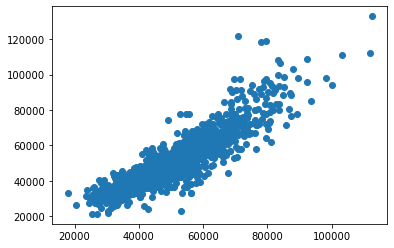

In [27]:
plt.scatter(x = linearSpec.fittedvalues, y = ba_ml['MD_EARN_WNE_P10']);

#### Size effects

In [28]:
results = pd.DataFrame(linearSpec.params, columns = ['Estimate']).join(pd.DataFrame(linearSpec.tvalues, columns=['tstat'])).join(pd.DataFrame(linearSpec.pvalues, columns=['pval']))
sigresults = results.query('pval < 0.05')
sigresults['size'] = abs(sigresults['Estimate'])
sigresults.sort_values(by=['size'], ascending=False)

,Estimate,tstat,pval,size
UGDS_ASIAN,41282.764310,8.226887,3.957207e-16,41282.764310
major_stem_quant,31502.233436,12.967093,1.269640e-36,31502.233436
major_career,26311.811358,7.884602,5.821468e-15,26311.811358
major_business,25836.268646,10.174333,1.343589e-23,25836.268646
major_ts,21018.844127,9.059029,3.764131e-19,21018.844127
UGDS_NRA,-20612.820203,-4.786646,1.853702e-06,20612.820203
PCTPELL,-17615.221921,-7.605518,4.832463e-14,17615.221921
ccbasic_27,16598.740826,4.359688,1.386210e-05,16598.740826
major_stem_nonquant,12902.623789,4.535315,6.183654e-06,12902.623789
ccbasic_26,12482.159092,7.898744,5.219952e-15,12482.159092


The share of Asians in an institution has the largest effect on median earnings. However, given the high collinearity in the explanatory variables these results should be treated with caution. For example, the shares of some majors such as health can be correlated with the type of institution (CCBASIC). Additional specification searches are warranted here but another approach would be to use machine learning to see how well the explanatory variables predict the outcomes. However, as in the predictive ML approach the features can only be interpreted as correlational rather than causal.

### Explore other regression specification

This specification has fewer explanatory variables. Specifically, a subset of the CCBASIC, undergraduate characteristics, major shares, and economic conditions are used. The nearest neighbor imputed test score is also used instead.

In [29]:
specRegression(X = ba_ml[inst_char[0:6] + ccbasic[1:20] + inst_qual + inst_ugdschar[0:6] + inst_major[0:2] 
+ inst_major[3:6] + [test_scores[2]]+ [econ_var[2]]],
y = np.log(ba_ml['MD_EARN_WNE_P10']), addConstant=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     152.3
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:19:34   Log-Likelihood:                 1171.6
No. Observations:                1631   AIC:                            -2269.
Df Residuals:                    1594   BIC:                            -2069.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.7741      0.054    143.056      0.000       7.668       7.881
admrate                -0.0377      0.018     -2.095      0.036      -0.073      -0.002
C150_4                  0.1296      0.030      4.320      0.000       0.071       0.189
RET_FT4                 0.1244      0.035      3.513      0.000       0.055       0.194
Private for-profit      2.6190      0.022    117.287      0.000       2.575       2.663
Private nonprofit       2.6036      0.019    138.333      0.000       2.567       2.641
Public                  2.5515      0.019    133.353      0.000       2.514       2.589
ccbasic_16              0.0480      0.016      2.961      0.003       0.016       0.080
ccbasic_17              0.0695      0.017      4.007      0.000       0.035       0.103
ccbasic_18              0.0738      0.015      4.802      0.000       0.044       0.104
ccbasic_19              0.0843      0.017      4.839      0.000       0.050       0.118
ccbasic_20              0.0352      0.019      1.843      0.066      -0.002       0.073
ccbasic_21              0.0558      0.016      3.447      0.001       0.024       0.088
ccbasic_22              0.0448      0.018      2.557      0.011       0.010       0.079
ccbasic_23              0.0258      0.046      0.564      0.573      -0.064       0.115
ccbasic_24              0.0177      0.031      0.576      0.564      -0.043       0.078
ccbasic_25           2.908e-11   2.37e-12     12.271      0.000    2.44e-11    3.37e-11
ccbasic_26              0.2473      0.027      9.033      0.000       0.194       0.301
ccbasic_27              0.2314      0.073      3.170      0.002       0.088       0.375
ccbasic_28              0.2130      0.064      3.330      0.001       0.088       0.338
ccbasic_29              0.1164      0.033      3.570      0.000       0.052       0.180
ccbasic_30             -0.1438      0.027     -5.300      0.000      -0.197      -0.091
ccbasic_31           6.567e-16   4.25e-17     15.458      0.000    5.73e-16     7.4e-16
ccbasic_32              0.0059      0.064      0.092      0.927      -0.119       0.131
ccbasic_33             -0.1956      0.091     -2.140      0.032      -0.375      -0.016
AVGFACSAL            3.005e-05   2.45e-06     12.268      0.000    2.52e-05    3.49e-05
PFTFAC                 -0.0169      0.013     -1.265      0.206      -0.043       0.009
PCTPELL                -0.4840      0.038    -12.614      0.000      -0.559      -0.409
UGDS_WOMEN             -0.1726      0.030     -5.832      0.000      -0.231      -0.115
UGDS_WHITE              0.1654      0.039      4.210      0.000       0.088       0.242
UGDS_BLACK              0.1538      0.042      3.665      0.000       0.071       0.236
UGDS_HISP               0.3223      0.047      6.862      0.000       0.230       0.414
UGD

The $R^2$ remains at around 78 percent. Even with a smaller set of explanatory variables there is not a significant decrease in the explanatory power of the model.

## Machine learning approach

The ML approach is preferred if the goal is to predict the outcome. The 'traditional' analytics approach uses the entire data set and likely would overfit the model. This implies that the model would not predict well out of sample.

### Preprocessing

In [30]:
from sklearn.preprocessing import StandardScaler

def createTrainTest(df, size, rs=402, Xvar=inst_char + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]] + econ_var):
    y = df['MD_EARN_WNE_P10']
    X = df[Xvar]
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=size,random_state=rs)
    scaler = StandardScaler().fit(train_X)
    train_X_std, test_X_std, X_std = scaler.transform(train_X), scaler.transform(test_X), scaler.transform(X)

    return (train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y)

train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(ba_ml, 0.3)

In [31]:
# Check scaling
# pd.DataFrame(train_X_std, columns = train_X.columns).describe()

### ML algorithms

Several machine learning algorithms are considered.
1. Linear models:
    - Linear regression
    - Bayesian ridge regression
    - Ridge regression
    - Lasso
    - Lasso with Least Angle Regression
    - ElasticNet
    - Automatic relevance detection regression
    - Ridge regression with cross validation
2. Survey vector regression
3. Decision tree regressor
4. Nearest neighbor
5. Ensemble methods:
    - Random forest regressor
    - AdaBoost
    - Gradient boosting

In [32]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

def get_cross(model, data, target, groups=10):
    return cross_val_score(model, data, target, cv=groups, scoring='neg_mean_squared_error')

### Using default parameters from sklearn

The algorithms are evaluated in two ways:
1. The error on the hold-out test data set
2. Cross validation error using 10-folds on the entire data set.

As is common practice performance is evaluated using the test data with the cross-validation presented for comparison purposes. Also presented are results using scaled and unscaled features. Since the scale of the features can impact some ML algorithms, results using standardized features are evaluated rather than unscaled features.

In [33]:
# From david paper: Chapter 4 if Hands On Machine Learning Applications: Data Science Fundamentals with Python
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor as rfr, AdaBoostRegressor as ada, GradientBoostingRegressor as gbr
from sklearn.linear_model import LinearRegression as lr, BayesianRidge as bay, Ridge as rr, Lasso as l, LassoLars as ll, ElasticNet as en, ARDRegression as ard, RidgeCV as rcv
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as dtr
from sklearn.neighbors import KNeighborsRegressor as knn

regressors = [lr(), 
bay(), 
rr(alpha=.5, random_state=0), 
l(alpha=0.1, random_state=0), 
ll(), 
knn(), 
ard(), 
rfr(random_state=0, n_estimators=100),
SVR(gamma='scale', kernel="linear"),
rcv(fit_intercept=False), 
en(random_state=0),
dtr(random_state=0), 
ada(random_state=0),
gbr(random_state=0)]

def get_error(model, Xtest, ytest):
    y_pred = model.predict(Xtest)
    return np.sqrt(mean_squared_error(ytest, y_pred)), model.__class__.__name__

def getMLresults(trainX, trainY, testX, testY, Type, runType):
    for reg in regressors:
        reg.fit(trainX, trainY)
        # test error
        rmse, name = get_error(reg, testX, testY)
        # cross-validation error using training
        scores = get_cross(reg, trainX, trainY)
        cverr = np.sqrt(np.mean(np.abs(scores)))
        name = reg.__class__.__name__
        results.append({Type: runType, 'method': name, 'error': rmse, 'cverr': cverr})

    return results

results = []
br = '\n'
# print ('unscaled:', br)
results = getMLresults(train_X, train_y, test_X, test_y, 'Scaled', 'No')

# print ('scaled:', br)
results = getMLresults(train_X_std, train_y, test_X_std, test_y, 'Scaled', 'Yes')
results = pd.DataFrame(results)

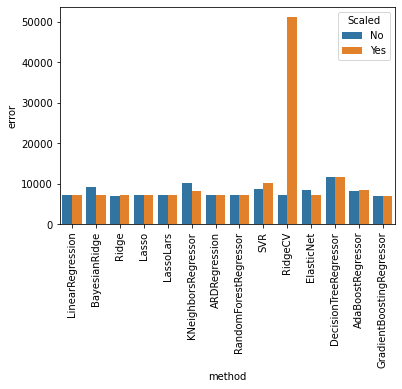

In [34]:
import seaborn as sns

summchart = sns.barplot(x='method', y='error', hue='Scaled', data=results)
summchart.set_xticklabels(rotation=90, labels=summchart.get_xticklabels());

In [35]:
pd.set_option('display.float_format', lambda x: '%8.0f' % x)
results.sort_values(['Scaled','error'], ascending=True).groupby('Scaled').head(30)

,Scaled,method,error,cverr
13,No,GradientBoostingRegressor,6976,6315
2,No,Ridge,7032,6498
6,No,ARDRegression,7079,6511
4,No,LassoLars,7102,6503
9,No,RidgeCV,7183,6638
3,No,Lasso,7187,6515
0,No,LinearRegression,7192,6525
7,No,RandomForestRegressor,7222,6672
12,No,AdaBoostRegressor,8276,7911
10,No,ElasticNet,8412,8305


In all cases, the ML approach does not have a lower RMSE than the traditional analytical approach. As expected the out of sample RMSE for the linear regression is $7,200 which is higher than the traditional approach. Looking at the test errors using scaled data, linear models appear to have similar out of sample errors - the lowest is the ARD regression with an out-of-sample error of $7,100 and the highest is the lasso regression at $7,200. 

Among the ensemble learning approaches, the gradient boosting regressor has the best predictive ability with an out-of-sample error of $7,000 although the difference is small compared to the other regression approaches. Using 10-fold cross-validation on the training data set mostly preserves the ranking of errors computed using the test data. One surprise is the large error using linear regression and cross validation.

### Hyperparameter tuning for ML algorithms

Most machine learning algorithms come with hyperparameters that can be tuned to obtain better predictive abilities. Instead of an exhaustive search over the real space of the hyperparameters, a gridded search with pre-specified values is used. While this will usually not result in the best predictive model, it may have a better cost-benefit tradeoff of runtime versus better predictions.

#### Definitions for tuning

The metric for evaluation of the algorithm is changed slightly. Two metrics are used:
1. The RMSE on the test data set
2. The average RMSE on a 10-fold cross validation on the test data set.

#### Tuning ARD (automatic relevance detection of Bayesian regression)

In [36]:
def ARDtune(trainX, trainY, testX, testY):
    ARD = ard()
    alpha_1 = [1e-6, 1e-10, 1e-4, 1e-2]
    alpha_2 = [1e-6, 1e-10, 1e-4, 1e-2]
    lambda_1 = [1e-6, 1e-10, 1e-4, 1e-2]
    lambda_2 = [1e-6, 1e-10, 1e-4, 1e-2]
    params = {'alpha_1': alpha_1, 'alpha_2': alpha_2, 'lambda_1': lambda_1, 'lambda_2': lambda_2}
    grid = GridSearchCV(ARD, params, cv=10, n_jobs=-1, verbose=1)
    grid.fit(trainX, trainY)
    bp = grid.best_params_
    print ("Best parameters: ", bp, br)

    ARD = ard(**bp).fit(trainX, trainY)
    rmse, name = get_error(ARD, testX, testY)
    print ("Best parameter ARD: ", rmse, br)

    scores = get_cross(ARD, trainX, trainY)
    rmse = np.sqrt(np.mean(scores) * -1)
    print ("Best parameter score: ", rmse, br)

ARDtune(trainX=train_X_std, trainY=train_y, testX=test_X_std, testY=test_y)
   

Fitting 10 folds for each of 256 candidates, totalling 2560 fits
Best parameters:  {'alpha_1': 0.01, 'alpha_2': 0.0001, 'lambda_1': 1e-06, 'lambda_2': 1e-06} 

Best parameter ARD:  7061.1197724772455 

Best parameter score:  6499.250173095956 



#### Tuning Lasso Lars

In [37]:
def lassoLarsTune(trainX, trainY, testX, testY):
    lassol = ll(random_state=0, alpha=0.1)
    alpha_lasso = [0.005, 0.01, 0.1]
    params = {'alpha': alpha_lasso}
    grid = GridSearchCV(lassol, params, cv=10, n_jobs=-1, verbose=1)
    grid.fit(trainX, trainY)
    bp = grid.best_params_
    print ("Best parameters: ", bp, br)
    
    lasso = ll(**bp, random_state = 0).fit(trainX, trainY)
    rmse, name = get_error(lasso, testX, testY)
    print ("Best parameter lasso: ", rmse, br)

    scores = get_cross(lasso, trainX, trainY)
    rmse = np.sqrt(np.mean(scores) * -1)
    print ("Best parameter score: ", rmse, br)

lassoLarsTune(trainX=train_X_std, trainY=train_y, testX=test_X_std, testY=test_y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best parameters:  {'alpha': 0.1} 

Best parameter lasso:  7179.585990673765 

Best parameter score:  6509.083007099306 



#### Tuning lasso

In [38]:
def lassoTune(trainX, trainY, testX, testY):
    lasso = l(random_state=0, alpha=0.1)
    alpha_lasso = [0.005, 0.01, 0.1]
    params = {'alpha': alpha_lasso}
    grid = GridSearchCV(lasso, params, cv=10, n_jobs=-1, verbose=1)
    grid.fit(trainX, trainY)
    bp = grid.best_params_
    print ("Best parameters: ", bp, br)

    lasso = l(**bp, random_state = 0).fit(trainX, trainY)
    rmse, name = get_error(lasso, testX, testY)
    print ("Best parameter lasso: ", rmse, br)

    scores = get_cross(lasso, trainX, trainY)
    rmse = np.sqrt(np.mean(scores) * -1)
    print ("Best parameter score: ", rmse, br)

lassoTune(trainX=train_X_std, trainY=train_y, testX=test_X_std, testY=test_y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best parameters:  {'alpha': 0.1} 

Best parameter lasso:  7192.062857286935 

Best parameter score:  6514.157263230498 



#### Tuning random forest regressor

In [39]:
def rfrTune(trainX, trainY, testX, testY):
    rf = rfr(random_state=0)
    n_estimators_rfr = [10, 50, 100]
    params = {'n_estimators': n_estimators_rfr}
    grid = GridSearchCV(rf, params, cv=10, n_jobs=-1, verbose=1)
    grid.fit(trainX, trainY)
    bp = grid.best_params_
    print ("Best parameters: ", bp, br)

    rf = rfr(**bp, random_state = 0).fit(trainX, trainY)
    rmse, name = get_error(rf, testX, testY)
    print ("Best parameter rfr: ", rmse, br)

    scores = get_cross(rf, trainX, trainY)
    rmse = np.sqrt(np.mean(scores) * -1)
    print ("Best parameter score: ", rmse, br)

rfrTune(trainX=train_X_std, trainY=train_y, testX=test_X_std, testY=test_y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best parameters:  {'n_estimators': 100} 

Best parameter rfr:  7215.992109909469 

Best parameter score:  6669.278614952219 



#### Tuning gradient boosting

In [40]:
def gbrTune(trainX, trainY, testX, testY):
    gb = gbr(random_state=0)
    n_estimators_gbr = [10, 50, 100]
    params = {'n_estimators': n_estimators_gbr}
    grid = GridSearchCV(gb, params, cv=10, n_jobs=-1, verbose=1)
    grid.fit(trainX, trainY)
    bp = grid.best_params_
    print ("Best parameters: ", bp, br)

    gb = gbr(**bp, random_state = 0).fit(trainX, trainY)
    rmse, name = get_error(gb, testX, testY)
    print ("Best parameter rfr: ", rmse, br)

    scores = get_cross(gb, trainX, trainY)
    rmse = np.sqrt(np.mean(scores) * -1)
    print ("Best parameter score: ", rmse, br)

gbrTune(trainX=train_X_std, trainY=train_y, testX=test_X_std, testY=test_y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best parameters:  {'n_estimators': 100} 

Best parameter rfr:  6975.680577228294 

Best parameter score:  6301.92440936209 



#### Tuning artificial neural networks

In [41]:
from sklearn.neural_network import MLPRegressor

def annTune(trainX, trainY, testX, testY):
    ann = MLPRegressor(random_state=0, max_iter=500)
    hlayers = [(5000,), (1000,), (100,50,10), (200,100,50,10)]
    params = {'hidden_layer_sizes': hlayers}
    grid = GridSearchCV(ann, params, cv=10, n_jobs=-1, verbose=1)
    grid.fit(trainX, trainY)
    bp = grid.best_params_
    print ("Best parameters: ", bp, br)

    ann = MLPRegressor(**bp, random_state = 0, max_iter=500).fit(trainX, trainY)
    rmse, name = get_error(ann, testX, testY)
    print ("Best parameter rfr: ", rmse, br)

    scores = get_cross(ann, trainX, trainY)
    rmse = np.sqrt(np.mean(scores) * -1)
    print ("Best parameter score: ", rmse, br)

annTune(trainX=train_X_std, trainY=train_y, testX=test_X_std, testY=test_y)


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best parameters:  {'hidden_layer_sizes': (100, 50, 10)} 

Best parameter rfr:  7591.007053889321 

Best parameter score:  7632.889718487275 



Based on the above three regressors, tuning using cross validation on the test data set does not appear to improve the predictive ability of the ML approaches. Note: David Paper's book cross validates on the entire data set which is not the approach taken here.

#### Tuning and scoring within GridSearchCV

Instead of tuning each algorithm and scoring on the test data, we can also score on the entire data. Instead of defining each algorithm separately, grid search is used.

In [44]:
tune_reg = [l(), rfr(), knn(), ll(), en(), gbr(), ard()]
alpha = [0.005, 0.01, 0.1]
n_estimators = [10, 50, 100]
knn_num = [5, 10, 15, 20]
alpha_ = [1e-6, 1e-10, 1e-4, 1e-2]
lambda_ = [1e-6, 1e-10, 1e-4, 1e-2]

tune_params = [{'alpha': alpha, 'random_state': [0]}, 
{'n_estimators': n_estimators, 'random_state': [0]},
{'n_neighbors': knn_num},
{'alpha': alpha, 'random_state': [0]},
{'alpha': alpha, 'random_state': [0], 'l1_ratio': [0.1, 0.5, 0.9]},
{'n_estimators': n_estimators, 'random_state': [0]},
{'alpha_1': alpha_, 'alpha_2': alpha_, 'lambda_1': lambda_, 'lambda_2': lambda_}]

def GS(trainX, trainY, testX, testY, X, y):
    for reg, tune in zip(tune_reg, tune_params):
        grid = GridSearchCV(reg, tune, cv=10, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error', refit=True)
        grid.fit(trainX, trainY)
        # print ("Best parameters: ", reg.__class__.__name__, br, grid.best_params_, br)
        # print()
        y_true, y_pred = testY, grid.predict(testX)
        testError = np.sqrt(mean_squared_error(y_true, y_pred))
        # print(np.sqrt(mean_squared_error(y_true, y_pred)))
        # print()
        y_true, y_pred = y, grid.predict(X)
        fullDataError = np.sqrt(mean_squared_error(y_true, y_pred))
        # print(np.sqrt(mean_squared_error(y_true, y_pred)))
        results.append({'Name': reg.__class__.__name__, 'Best param': grid.best_params_, 
        'Test error': testError, 'Full error': fullDataError})

    return results

results = []
results = GS(trainX=train_X_std, trainY=train_y, testX=test_X_std, testY=test_y, X=X_std, y=y)

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 10 folds for each of 3 candidates, totalling 30 fits
Fitting 10 folds for each of 256 candidates, totalling 2560 fits


In [46]:
pd.DataFrame(results).sort_values('Full error')

,Name,Best param,Test error,Full error
1,RandomForestRegressor,"{'n_estimators': 100, 'random_state': 0}",7216,4450
5,GradientBoostingRegressor,"{'n_estimators': 100, 'random_state': 0}",6976,4826
6,ARDRegression,"{'alpha_1': 0.01, 'alpha_2': 0.0001, 'lambda_1...",7061,6353
4,ElasticNet,"{'alpha': 0.01, 'l1_ratio': 0.5, 'random_state...",7163,6366
3,LassoLars,"{'alpha': 0.1, 'random_state': 0}",7180,6370
0,Lasso,"{'alpha': 0.1, 'random_state': 0}",7192,6374
2,KNeighborsRegressor,{'n_neighbors': 5},8197,6647


There are some large differences in the results using ML methods. The random forest regressor is able to achieve a lower error using the full data with cross-validation of $4,400 or 8 to 9 percent of the mean and median outcome respectively. However, the random forest regressor does not have the lowest test error although the difference with the other algorithms is small.

#### Baseline best performing ML model parameters

Refit the random forest regressor from grid search manually and calculate the error

In [48]:
def randomForest(trainX, trainY, X, y, nest=100):
    rf = rfr(random_state=0, n_estimators=nest)
    rf.fit(trainX, trainY)

    y_pred = rf.predict(X)
    return (y_pred, np.sqrt(mean_squared_error(y, y_pred)), rf)

y_pred, best_rmse_rfr, rfobj = randomForest(trainX=train_X_std, trainY=train_y, X=X_std, y=y)
best_rmse_rfr

4449.518943163918

Plot the predicted versus the actual from the random forest regressor

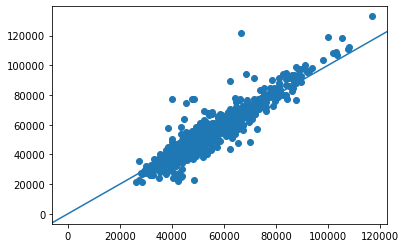

In [45]:
plt.scatter(x = y_pred, y = y);
plt.axline([0, 0], [1, 1]);

Compare the plot from the random forest regressor with the traditional approach. There is a tighter fit from the random forest regressor.

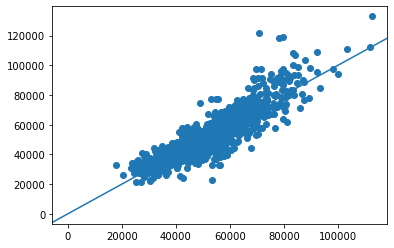

In [46]:
plt.scatter(x = linearSpec.fittedvalues, y = ba_ml['MD_EARN_WNE_P10']);
plt.axline([0, 0], [1, 1]);

#### Doubling down on the random forest regressor to search for a better fit

The search is expanded by changing the number of estimators to try.

In [49]:
def randomForestGrid(trainX, trainY, X, y, nest=[100,125,150,175], mf=['sqrt']):
    grid = GridSearchCV(rfr(random_state=0), {'n_estimators': nest, 'max_features': mf}, cv=10, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error', refit=True)
    grid.fit(trainX, trainY)
    print ("Best parameters: ", rfr().__class__.__name__, br, grid.best_params_, br)
    # print()
    # y_true, y_pred = test_y, grid.predict(test_X_std)
    # print(np.sqrt(mean_squared_error(y_true, y_pred)))
    # print()
    y_true, y_pred = y, grid.predict(X)
    return (grid.best_params_, np.sqrt(mean_squared_error(y_true, y_pred)), grid)

bp, rmse, grid = randomForestGrid(trainX=train_X_std, trainY=train_y, X=X_std, y=y)
rmse


Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best parameters:  RandomForestRegressor 
 {'max_features': 'sqrt', 'n_estimators': 175} 



4409.8809471366885

This not a large improvement, so for now, we'll keep the number of estimators at 100

## Can we do better by changing the test-train split?

The random forest regressor appears to be performing well. Can this be improved by increasing the training data size even though this may increase the risk of overfitting.

In [50]:
train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(ba_ml, 0.2)
bp, rmse, grid = randomForestGrid(trainX=train_X_std, trainY=train_y, X=X_std, y=y)
rmse

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best parameters:  RandomForestRegressor 
 {'max_features': 'sqrt', 'n_estimators': 125} 



3944.9099079841844

The test error falls further to $3,900 or 7 to 8 percent of the mean and median of the outcome respectively. The size of the improvement is relatively small.

### How sensitive is this improvement to a change in the random number?

Here the search grid is also changed to include larger number of estimators and the train-test split is changed back to its 70-30 split

In [53]:
train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(ba_ml, 0.3, rs=2800)
bp, rmse, grid = randomForestGrid(trainX=train_X_std, trainY=train_y, X=X_std, y=y)
rmse

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best parameters:  RandomForestRegressor 
 {'max_features': 'sqrt', 'n_estimators': 125} 



4123.658635240225

The grid search finds another estimator for a better fit - 125 versus 100. The size of error falls to $4,100 or 7 percent of both the mean and median of the outcome. This is not a large improvement. The predictive ability does not appear to be sensitive to a change in random number or a change in the number of estimators.

## Improving the performance of the random forest regressor

### Increasing the search parameters in the random forest

The search space is extended to search over the maximum number of features to include in a tree.

In [54]:
train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(ba_ml, 0.3, rs=402)
bp, rmse, grid = randomForestGrid(trainX=train_X_std, trainY=train_y, X=X_std, y=y, nest=[100,125,150,175], mf=['sqrt', 'log2', None, 0.8])
rmse

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters:  RandomForestRegressor 
 {'max_features': 0.8, 'n_estimators': 175} 



4403.766840309654

Increasing the search space to include maximum features does not improve the accuracy much.

### Increasing the training data by using all the data from one year and the test data from another

Train on all 2018-2019 data.

In [55]:
y_pred, rmse, rfobj = randomForest(trainX=X_std, trainY=y, X=X_std, y=y)
rmse

2421.083466897147

The low average error of $2,400 is an indication that the random forest regressor is overfitting the data.

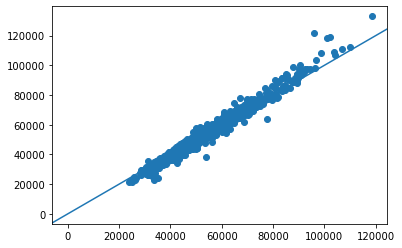

In [56]:
plt.scatter(x = y_pred, y = ba_ml['MD_EARN_WNE_P10']);
plt.axline([0, 0], [1, 1]);

Get 2014-2015 data as test data

In [57]:
(scard1415, scard_metadata1415, vars_to_use1415, major_cols) = getdata('MERGED2014_15_PP.csv')
scard_ml1415 = createVars(scard1415, major_cols=major_cols)
scard_ml1415.dropna(subset=['MD_EARN_WNE_P10'], inplace=True)
scard_ml1415 = getAdditionalData(df = scard_ml1415, lau = "laucnty14.xlsx", saipe = "est14all.xls", unempyear=2014)


In [58]:
ba_ml1415 = scard_ml1415.loc[scard_ml1415.PREDDEG == "Predominantly bachelor's"]
ba_ml1415 = imputeWithLinearRegression(df=ba_ml1415, X=['PCTPELL', 'admrate'], y=['ACTCMMID'])
ba_ml1415.drop(axis = 1, columns = ['SATVRMID', 'SATWRMID', 'SATMTMID', 'ACTWRMID', 'ACTCMMID', 'ACTMTMID', 'OPENADMP', 'PREDDEG', 'UNITID', 'OPEID', 'OPEID6', 'MAIN', 
'ICLEVEL', 'C150_L4', 'ST_FIPS', 'CONTROL', 'HIGHDEG', 'ADM_RATE', 'RET_FTL4'], inplace = True)
ba_ml1415.dropna(inplace=True)
y_test1415 = ba_ml1415['MD_EARN_WNE_P10'] * 376.5/348.9 # adjust to 2019 dollars
X_test1415 = ba_ml1415[inst_char + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]] + econ_var]
X_test1415['AVGFACSAL'] = X_test1415['AVGFACSAL'] * 376.5/348.9
X_test1415['median_hh_inc'] = X_test1415['median_hh_inc'] * 376.5/348.9
test_X_std1415 = StandardScaler().fit(X).transform(X_test1415) # scale using training data means

Fit to 2014-2015 data

In [59]:
y_pred1415 = rfobj.predict(test_X_std1415)
print(np.sqrt(mean_squared_error(y_test1415, y_pred1415)))

6326.003583470765


The average error increases to $6,300 similar to the linear specification. This suggests that the model does not generalize to different years.

One last data exploration to consider is to go back to the original data from 2018-2019 and see if following a recipe of imputing missingness with medians will increase the accuracy of the random forest regressor.

### Imputing to fill all 2018-2019 data to increase training data

In [60]:
ba_ml_full = scard_ml.loc[(scard_ml.PREDDEG == "Predominantly bachelor's") & (scard_ml.MD_EARN_WNE_P10)] 
ba_ml_full = imputeWithLinearRegression(df=ba_ml_full, X=['PCTPELL', 'admrate'], y=['ACTCMMID'])
# ba_ml_full.drop(axis = 1, columns = ['SATVRMID', 'SATMTMID', 'ACTCMMID', 'ACTMTMID', 'OPENADMP', 'PREDDEG', 'UNITID', 'OPEID', 'OPEID6', 'MAIN', 
# 'ICLEVEL', 'C150_L4', 'ST_FIPS', 'CONTROL', 'HIGHDEG', 'ADM_RATE', 'RET_FTL4'], inplace = True)
imputerM = impute.SimpleImputer(missing_values=np.nan, strategy='median')
ba_ml_full_imp = imputerM.fit_transform(ba_ml_full[inst_char + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]] + econ_var + ['MD_EARN_WNE_P10']])
ba_ml_full_imp = pd.DataFrame(ba_ml_full_imp, columns=[inst_char + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]] + econ_var + ['MD_EARN_WNE_P10']])
ba_ml_full_imp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
admrate,1813,1,0,0,1,1,1,1
C150_4,1813,1,0,0,0,1,1,1
RET_FT4,1813,1,0,0,1,1,1,1
Private for-profit,1813,0,0,0,0,0,0,1
Private nonprofit,1813,1,0,0,0,1,1,1
Public,1813,0,0,0,0,0,1,1
hasGradSchool,1813,1,0,0,1,1,1,1
ccbasic_15,1813,0,0,0,0,0,0,1
ccbasic_16,1813,0,0,0,0,0,0,1
ccbasic_17,1813,0,0,0,0,0,0,1


In [61]:
train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(ba_ml_full_imp, 0.3)
y_pred, rmse, rfobj = randomForest(trainX=train_X_std, trainY=train_y, X=X_std, y=y)
rmse


4255.220365498096

The test error from using a data set that fills NaN with medians is comparable to the RMSE of a random forest regressor with expanded search grid.

## Feature engineering

This section explores whether expanding the number of features via feature engineering can improve the predictions. Specifically, some features are expanded to include polynomials and interaction effects. The features expanded are the non-dummy variables from the institutional characteristics, institutional quality, major shares, undergraduate characteristics and the predicted test score.

In [62]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
p = poly.fit(ba_ml[inst_char[0:3] + inst_qual + inst_major + inst_ugdschar + [test_scores[0]]])
pfeatures = poly.transform(ba_ml[inst_char[0:3] + inst_qual + inst_major + inst_ugdschar + [test_scores[0]]])
pfeatures = pd.DataFrame(pfeatures, columns = poly.get_feature_names_out())
c = inst_char[3:8] + ccbasic + econ_var + ['MD_EARN_WNE_P10']
for var in c:
    pfeatures[var] = ba_ml[var].to_numpy()

# pfeatures['MD_EARN_WNE_P10'].describe()

allfeatures = inst_char[3:8] + list(poly.get_feature_names_out()) + econ_var

In [76]:
train_X, test_X, train_y, test_y, train_X_std, test_X_std, X_std, X, y = createTrainTest(pfeatures, 0.3, Xvar=allfeatures)
y_pred, rmse, rfobj = randomForest(trainX=train_X_std, trainY=train_y, X=X_std, y=y)
rmse


4549.868165569225

The average error from using additional polynomial features is slightly higher at $4,500 compared to the baseline random forest best fit of $4,400.

### Role of early earnings

The College Scorecard also has data on earnings prior to 10 years after enrollment. The earliest year is the 6th year after enrollment. Can early earnings add to the predictive ability of a linear model using the traditional analytics approach?

In [77]:
ba_ml_P6P10 = ba_ml_1819.drop('MD_EARN_WNE_P6', axis=1).merge(scard1415[['UNITID', 'MD_EARN_WNE_P6']])
ba_ml_P6P10['MD_EARN_WNE_P6'] = ba_ml_P6P10['MD_EARN_WNE_P6'] * 376.5/348.9 # inflation-adjusted to 2019 dollars
ba_ml_P6P10.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
UNITID,1796,206961,89164,100654,154457,190642,219308,485272
OPEID,1796,958878,4566203,100200,200675,296100,376725,82098876
OPEID6,1796,5580,7814,1002,2007,2961,3767,41483
MAIN,1796,1,0,0,1,1,1,1
ST_FIPS,1796,30,15,1,17,31,42,56
...,...,...,...,...,...,...,...,...
state_urate,1796,4,1,2,3,4,4,6
ACTCMMID_pred,1716,23,4,9,20,22,25,36
ACTCMMID_medfill,1796,23,3,15,22,23,24,36
ACTCMMID_knn,1796,23,4,15,20,22,25,36


In [78]:
linearSpec = specRegression(X = ba_ml_P6P10[['MD_EARN_WNE_P6'] + inst_char[0:6] + ccbasic + inst_qual + inst_ugdschar + inst_major + [test_scores[0]]+ econ_var],
y = ba_ml_P6P10['MD_EARN_WNE_P10'], addConstant=0)

linearSpec.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     490.2
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:12:19   Log-Likelihood:                -15415.
No. Observations:                1610   AIC:                         3.092e+04
Df Residuals:                    1565   BIC:                         3.116e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
MD_EARN_WNE_P6          0.9052      0.016     57.574      0.000       0.874       0.936
admrate               414.4665    584.615      0.709      0.478    -732.245    1561.178
C150_4               4601.4001    910.334      5.055      0.000    2815.798    6387.003
RET_FT4              2699.7232   1079.856      2.500      0.013     581.606    4817.840
Private for-profit  -1887.4274   2612.194     -0.723      0.470   -7011.196    3236.341
Private nonprofit   -2669.3742   2579.408     -1.035      0.301   -7728.834    2390.085
Public              -3271.8477   2594.824     -1.261      0.208   -8361.546    1817.851
ccbasic_15          -3012.6033    744.934     -4.044      0.000   -4473.777   -1551.430
ccbasic_16          -1371.2046    686.053     -1.999      0.046   -2716.884     -25.525
ccbasic_17          -1810.3663    670.753     -2.699      0.007   -3126.036    -494.697
ccbasic_18           -918.2527    618.136     -1.486      0.138   -2130.714     294.208
ccbasic_19           -602.0096    637.881     -0.944      0.345   -1853.201     649.182
ccbasic_20          -1095.0586    667.295     -1.641      0.101   -2403.944     213.827
ccbasic_21            912.3506    649.953      1.404      0.161    -362.519    2187.220
ccbasic_22           -241.7283    603.520     -0.401      0.689   -1425.521     942.065
ccbasic_23             12.3671   1332.807      0.009      0.993   -2601.909    2626.643
ccbasic_24          -1535.1291    950.357     -1.615      0.106   -3399.237     328.979
ccbasic_25          -3.257e-12   1.25e-11     -0.260      0.795   -2.78e-11    2.13e-11
ccbasic_26          -1638.7627    927.186     -1.767      0.077   -3457.420     179.894
ccbasic_27          -1119.1191   2526.637     -0.443      0.658   -6075.069    3836.831
ccbasic_28            941.0543   1795.300      0.524      0.600   -2580.392    4462.500
ccbasic_29          -1011.4834   1063.050     -0.951      0.342   -3096.637    1073.670
ccbasic_30           -446.9833    929.440     -0.481      0.631   -2270.062    1376.096
ccbasic_31           3.899e-13   7.29e-12      0.053      0.957   -1.39e-11    1.47e-11
ccbasic_32            639.3268   2068.278      0.309      0.757   -3417.562    4696.215
ccbasic_33           4468.9531   4759.217      0.939      0.348   -4866.161    1.38e+04
AVGFACSAL               0.7295      0.076      9.661      0.000       0.581       0.878
PFTFAC                302.4146    404.315      0.748      0.455    -490.641    1095.470
PCTPELL             -2615.0865   1341.054     -1.950      0.051   -5245.538      15.365
UGDS_WOMEN          -8324.0775    908.463     -9.163      0.000   -1.01e+04   -6542.144
UGDS_WHITE          -2079.2608   1706.093     -1.219      0.223   -5425.730    1267.209
UGDS_BLACK            208.1434   1746.447      0.119      0.905   -3217.479    3633.766
UGD

There is great predictive power when early earnings are added to the OLS specification. The $R^2$ increases to over 90 percent.

In [79]:
specRegression(X = ba_ml_P6P10['MD_EARN_WNE_P6'], y = ba_ml_P6P10['MD_EARN_WNE_P10'], addConstant=1).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        MD_EARN_WNE_P10   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 1.014e+04
Date:                Wed, 03 Aug 2022   Prob (F-statistic):               0.00
Time:                        16:13:28   Log-Likelihood:                -17672.
No. Observations:                1766   AIC:                         3.535e+04
Df Residuals:                    1764   BIC:                         3.536e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6440.4096    458.352     14.051      0.000    5541.440    7339.380
MD_EARN_WNE_P6     1.1400      0.011    100.688      0.000       1.118       1.162
==============================================================================
Omnibus:                      192.478   Durbin-Watson:                   1.542
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1411.206
Skew:                           0.203   Prob(JB):                    3.64e-307
Kurtosis:                       7.360   Cond. No.                     1.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In fact, early earnings alone explains 85 percent of the variation in later earnings. While this increases the predictability of the model it also leaves the model lacking since it's task would now be to predict early year earnings.